# Gene Set Recovery Results

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 3B-D
* Figure EV3A-E

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For implementation of the gene set recovery pipeline, see `ExampleUsage/GSR_GeneSetRecovery.README.md`

## Setup

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.data_import_export_tools import load_node_sets
from neteval.gene_set_recovery_results import *
from statsmodels.stats.multitest import fdrcorrection
from neteval.network_statistics import NetworkStats, load_network_names
from scipy.stats import spearmanr, skewtest, wilcoxon
import scipy.stats as stats
from statsmodels.stats.descriptivestats import sign_test
import warnings

In [2]:

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [3]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/GeneSetRecovery/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
genesets = [ 'gwas', 'disgen', 'gwas_230727', 'exp_genesets']
geneset_names = {'gwas' : 'Genetic', 
                'disgen':'Literature',
                'gwas_230727':'Genetic 2023+',
                'exp_genesets':'Experimental'}

## Example Analysis

Load the network statistics and file paths for the three example networks

In [4]:
pref_file = os.path.join(datadir, 'example_prefix_file.txt')

In [5]:
with open(pref_file, 'r') as f:
    prefixes = [pref.strip() for pref in f.readlines()]
    
stats = NetworkStats(pref_file, datadir=os.path.join(datadir, 'example_outputs/'))
example_network_names = load_network_names(os.path.join(gitdir,"Data/example_network_names.txt"))

Load the gene set recovery results

In [6]:
gsr_results = EvaluationResults(evaldir, prefixes, genesets = genesets, metrics = ['AUPRC', 'Performance', 'Gain'], verbose=True)
gsr_results.set_network_names(example_network_names)

For the Genetic 2023+ gene sets, keep only those after the cutoff date

In [7]:
# for the Gnetkeep only the gwsa that are after the cutoff date
drop_from_recent_gwas = [g for g in gsr_results.results['Performance']['gwas_230727'].index if '2023-07' not in g]
for met in gsr_results.results:
    gsr_results.results[met]['gwas_230727'].drop(index=drop_from_recent_gwas, inplace=True)

Perform size adjustment of recovery results and then rank all networks.  
Note: this is performed for illustrative purposes only. It is recommended that at least 10 networks be evaluated for using size-adjustment to avoid convergence issues. 

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gsr_results.size_adjusted_performances(sizes=stats.network_edge_counts, na_option='center')
    gsr_results.rank_all(na_option='center')

Access the performance metrics

In [9]:
gsr_results.results['Performance']['exp_genesets']

,dip,pid2,wan
Gou24_lung,NaN,NaN,0.419803
Hashimoto24,6.701156,-0.792871,0.330971
Kumbrink24_1v2,NaN,21.542769,NaN
Kumbrink24_2v3,167.469451,12.108419,NaN
Qian24_DEG_PANoptosis,100.953805,NaN,NaN
Reed24_Catabolic process module,6.007370,1.430714,3.005223
Reed24_Cell cycle module,20.117417,30.765690,18.245169
Reed24_Cellular response to stimulus module,18.986215,1.634364,NaN
Reed24_Endoplasmic reticulum module,33.901985,173.489417,16.313287
Reed24_Leukocyte module,45.304503,1.000865,53.796605


In [10]:
gsr_results.results['Performance_SzAdj']['disgen']

,dip,pid2,wan
ACTH-Secreting Pituitary Adenoma,8.267254e-11,-1.287432e-08,NaN
AICARDI-GOUTIERES SYNDROME,6.063691e-04,1.355613e-03,-9.368479
AIDS related complex,8.575010e-08,7.185804e-08,NaN
AMYOTROPHIC LATERAL SCLEROSIS 1,6.899246e-06,6.915787e-06,-1.273928
ATRICHIA WITH PAPULAR LESIONS,4.113282e-09,1.371571e-08,NaN
...,...,...,...
oligodendroglioma,-4.332723e-02,-2.162417e-02,2.075810
psychological distress,-2.420546e-09,-1.943298e-09,NaN
"stage, non-small cell lung cancer",3.593005e-05,1.688245e-05,-1.847012
synovial sarcoma,-2.890594e-06,-7.259157e-06,0.920294


Access the rankings

In [11]:
gsr_results.rankings

,AUPRC-gwas,AUPRC-disgen,AUPRC-gwas_230727,AUPRC-exp_genesets,Performance-gwas,Performance-disgen,Performance-gwas_230727,Performance-exp_genesets,Gain-gwas,Gain-disgen,...,AUPRC_SzAdj-gwas_230727,AUPRC_SzAdj-exp_genesets,Performance_SzAdj-gwas,Performance_SzAdj-disgen,Performance_SzAdj-gwas_230727,Performance_SzAdj-exp_genesets,Gain_SzAdj-gwas,Gain_SzAdj-disgen,Gain_SzAdj-gwas_230727,Gain_SzAdj-exp_genesets
dip,0.267327,0.202326,0.078947,-0.227273,-0.435644,-0.684884,-0.631579,-0.318182,-0.396040,-0.683721,...,-0.578947,-0.409091,-0.247525,-0.327907,-0.342105,-0.318182,-0.346535,-0.416279,-0.500000,-0.045455
pid2,-0.511111,-0.815476,-0.722222,-0.041667,0.300000,0.472619,0.416667,0.208333,0.111111,0.390476,...,-0.111111,-0.041667,-0.066667,-0.084524,-0.194444,0.041667,-0.066667,-0.117857,0.000000,-0.041667
wan,0.322034,0.754801,0.657143,0.375000,0.288136,0.283604,0.257143,0.125000,0.508475,0.384047,...,0.742857,0.625000,0.525424,0.521418,0.571429,0.375000,0.694915,0.675037,0.542857,0.125000


## Fig3B - Visualization of performance of all networks for Literature and Genetic gene sets.

Extract the results from Dataset EV2

In [12]:
gsr_full_results = pd.read_csv(os.path.join(gitdir,'StateOfTheInteractomes_Notebooks/Data/DatasetEV2.txt'), index_col=None, sep='\t')
main_networks = [net for net in gsr_full_results.Network.unique() if '-' not in net]
gsr_full_resutls = gsr_full_results[gsr_full_results.Network.isin(main_networks)]

In [13]:
full_network_rankings = pd.read_csv(os.path.join(gitdir,'StateOfTheInteractomes_Notebooks/Data/Fig3B_all_network_ranks.csv'), index_col=0)

In [33]:
full_network_rankings['order'] = full_network_rankings['Performance-'+'disgen'].rank(ascending=False, na_option='top', method='first')
full_network_rankings = full_network_rankings.sort_values(by='order', ascending=False)
full_network_rankings['bar_y'] = full_network_rankings['order'] +1.5
rank_dict = {j:i+1 for i, j in enumerate(range(-22, 23))}

Create the visualization

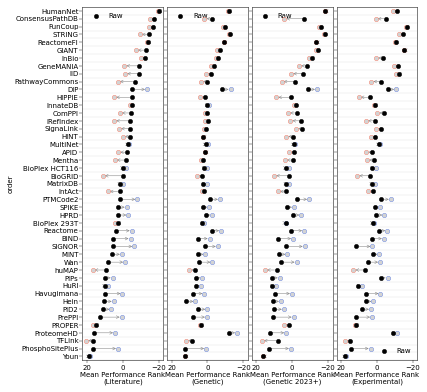

In [15]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for j, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= genesets[j]
    plt.sca(ax)
    ax.invert_xaxis()
    full_network_rankings['direction'] = (full_network_rankings["Performance-SzAdj-"+geneset] - full_network_rankings["Performance-"+geneset]) > 0
    rank_max = (rank_dict[(np.floor(full_network_rankings["Performance-"+geneset].max())) ]//5) * 5
    rank_min = (rank_dict[(np.ceil(full_network_rankings["Performance-"+geneset].min())) ]//5) * 5
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==True], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='tomato')
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==False], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='royalblue')
    sns.scatterplot(full_network_rankings, x="Performance-"+geneset, y='order', color='black', edgecolor='black', ax=ax, zorder=100, s=20, label='Raw')
    # add arrows between the pairs of points
    for i in range(len(full_network_rankings)):
        # create a pallete for the arrows
        if full_network_rankings['Performance-SzAdj-'+geneset][i] < full_network_rankings['Performance-'+geneset][i]:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
        else:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
    # add a horizontal grid between points
    for i in range(len(full_network_rankings)):
        ax.axhline(y=full_network_rankings['order'][i]-0.5, color='grey', lw=0.1, zorder=0)
    plt.ylim(0.5, len(full_network_rankings)+.5)
    # reorder the index of full_network_rankings based on the order column
    full_network_rankings = full_network_rankings.sort_values(by='order', ascending=False)
    _ = plt.yticks(full_network_rankings['order'], labels= full_network_rankings.index)
    plt.xlabel("Mean Performance Rank\n("+geneset_names[geneset]+")")
    ax.set_xlim(22.5, -22.5)
# map tick labels using the network names
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
ax1.set_ylabel("Network")
plt.savefig(os.path.join(figdir, "Fig3B_full_performance_results.jpg"), dpi=300, bbox_inches="tight")

## Thesis Figure

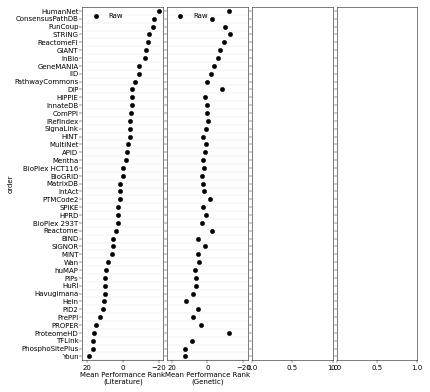

In [55]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for j, ax in enumerate([ax1, ax2]):
    geneset= genesets[j]
    plt.sca(ax)
    ax.invert_xaxis()
    full_network_rankings['direction'] = (full_network_rankings["Performance-SzAdj-"+geneset] - full_network_rankings["Performance-"+geneset]) > 0
    rank_max = (rank_dict[(np.floor(full_network_rankings["Performance-"+geneset].max())) ]//5) * 5
    rank_min = (rank_dict[(np.ceil(full_network_rankings["Performance-"+geneset].min())) ]//5) * 5
    #sns.scatterplot(full_network_rankings[full_network_rankings['direction']==True], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='tomato')
    #sns.scatterplot(full_network_rankings[full_network_rankings['direction']==False], x="Performance-SzAdj-"+geneset, y='order', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='royalblue')
    sns.scatterplot(full_network_rankings, x="Performance-"+geneset, y='order', color='black', edgecolor='black', ax=ax, zorder=100, s=20, label='Raw')
    # add arrows between the pairs of points

    # add a horizontal grid between points
    for i in range(len(full_network_rankings)):
        ax.axhline(y=full_network_rankings['order'][i]-0.5, color='grey', lw=0.1, zorder=0)
    plt.ylim(0.5, len(full_network_rankings)+.5)
    # reorder the index of full_network_rankings based on the order column
    full_network_rankings = full_network_rankings.sort_values(by='order', ascending=False)
    _ = plt.yticks(full_network_rankings['order'], labels= full_network_rankings.index)
    plt.xlabel("Mean Performance Rank\n("+geneset_names[geneset]+")")
    ax.set_xlim(22.5, -22.5)
# map tick labels using the network names
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
ax1.set_ylabel("Network")
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/Defense/3b_ordered_no_arrows.svg', bbox_inches='tight')

/tmp/ipykernel_3093381/3262759901.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])


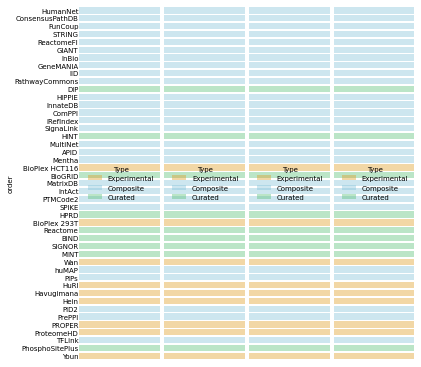

In [56]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= 'disgen'
    sns.barplot(full_network_rankings, x=48,y='order', orient='h', hue='Type',order=[float(i) for i in range(len(full_network_rankings), 0, -1)], dodge=False, palette=['#ffa500', '#73c7e7', '#44cf6c'], 
                zorder=0, alpha=0.4, ax=ax, hue_order=['Experimental', 'Composite', 'Curated'])
    #sns.barplot(full_network_rankings, x=48,y='order', orient='h', hue='Type',order=[float(i) for i in range(0, 48, 1)], dodge=False, palette='Set2', zorder=0, alpha=0.5, ax=ax)
    #sns.barplot(full_network_rankings, x='bar',y='bar_y', orient='h', order = full_network_rankings['order'], ax=ax, hue='Type', dodge=False, palette='Set2', zorder=0, alpha=0.5)
    # add arrows between the pairs of points
    ax.set_xlim(0,47)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(length=0)
    ax.set_xticks([])
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
#plt.savefig(figdir + "performance_arrow_plots_background_without_humannet.svg", dpi=300, bbox_inches="tight")
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/Defense/3b_ordered_background.svg', bbox_inches='tight')

In [51]:
full_network_rankings = full_network_rankings.sort_values(by='Performance-SzAdj-disgen', ascending=False)

In [52]:
full_network_rankings['order2'] = [float(i) for i in range(1, 46)]

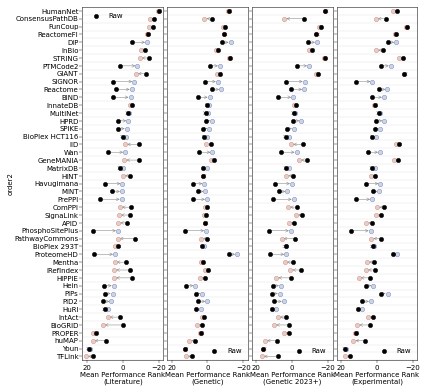

In [57]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for j, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= genesets[j]
    plt.sca(ax)
    ax.invert_xaxis()
    full_network_rankings['direction'] = (full_network_rankings["Performance-SzAdj-"+geneset] - full_network_rankings["Performance-"+geneset]) > 0
    rank_max = (rank_dict[(np.floor(full_network_rankings["Performance-"+geneset].max())) ]//5) * 5
    rank_min = (rank_dict[(np.ceil(full_network_rankings["Performance-"+geneset].min())) ]//5) * 5
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==True], x="Performance-SzAdj-"+geneset, y='order2', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='tomato')
    sns.scatterplot(full_network_rankings[full_network_rankings['direction']==False], x="Performance-SzAdj-"+geneset, y='order2', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='royalblue')
    sns.scatterplot(full_network_rankings, x="Performance-"+geneset, y='order2', color='black', edgecolor='black', ax=ax, zorder=100, s=20, label='Raw')
    # add arrows between the pairs of points
    for i in range(len(full_network_rankings)):
        # create a pallete for the arrows
        if full_network_rankings['Performance-SzAdj-'+geneset][i] < full_network_rankings['Performance-'+geneset][i]:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order2'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order2'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
        else:
            ax.annotate("", xy=(full_network_rankings['Performance-'+geneset][i], full_network_rankings['order2'][i]), 
                    xytext=(full_network_rankings['Performance-SzAdj-'+geneset][i], full_network_rankings['order2'][i]), 
                    arrowprops=dict(arrowstyle="<-", color='grey', lw=0.5))
    # add a horizontal grid between points
    for i in range(len(full_network_rankings)):
        ax.axhline(y=full_network_rankings['order2'][i]-0.5, color='grey', lw=0.1, zorder=0)
    plt.ylim(0.5, len(full_network_rankings)+.5)
    # reorder the index of full_network_rankings based on the order column
    full_network_rankings = full_network_rankings.sort_values(by='order2', ascending=False)
    _ = plt.yticks(full_network_rankings['order2'], labels= full_network_rankings.index)
    plt.xlabel("Mean Performance Rank\n("+geneset_names[geneset]+")")
    ax.set_xlim(22.5, -22.5)
# map tick labels using the network names
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
ax1.set_ylabel("Network")
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/Defense/3b_size_arrows.svg', bbox_inches='tight')

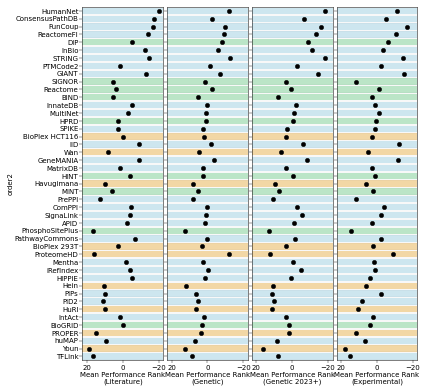

In [69]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for j, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= genesets[j]
    plt.sca(ax)
    ax.invert_xaxis()
    full_network_rankings['direction'] = (full_network_rankings["Performance-SzAdj-"+geneset] - full_network_rankings["Performance-"+geneset]) > 0
    rank_max = (rank_dict[(np.floor(full_network_rankings["Performance-"+geneset].max())) ]//5) * 5
    rank_min = (rank_dict[(np.ceil(full_network_rankings["Performance-"+geneset].min())) ]//5) * 5
    #sns.scatterplot(full_network_rankings[full_network_rankings['direction']==True], x="Performance-SzAdj-"+geneset, y='order2', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='tomato')
    #sns.scatterplot(full_network_rankings[full_network_rankings['direction']==False], x="Performance-SzAdj-"+geneset, y='order2', color='lightgrey', ax=ax, s=20, zorder=12, edgecolor='royalblue')
    sns.scatterplot(full_network_rankings, x="Performance-"+geneset, y='order2', color='black', 
                    edgecolor='black', ax=ax, zorder=100, s=20, label='Raw', legend=False)
    # add arrows between the pairs of points
    sns.barplot(full_network_rankings, x=48,y='order2', orient='h', hue='Type',
            order=[float(i) for i in range(len(full_network_rankings),-1, -1)][::-1], 
            dodge=False, palette=['#ffa500', '#73c7e7', '#44cf6c'], legend=False, 
            zorder=0, alpha=0.4, ax=ax, hue_order=['Experimental', 'Composite', 'Curated'])
    sns.barplot(full_network_rankings, x=-48,y='order2', orient='h', hue='Type', legend=False,
            order=[float(i) for i in range(len(full_network_rankings),-1, -1)][::-1], 
            dodge=False, palette=['#ffa500', '#73c7e7', '#44cf6c'], 
            zorder=0, alpha=0.4, ax=ax, hue_order=['Experimental', 'Composite', 'Curated'])
    for i in range(len(full_network_rankings)):
        ax.axhline(y=full_network_rankings['order2'][i]-0.5, color='grey', lw=0.1, zorder=0)
    plt.ylim(0.5, len(full_network_rankings)+.5)
    # reorder the index of full_network_rankings based on the order column
    full_network_rankings = full_network_rankings.sort_values(by='order2', ascending=False)
    _ = plt.yticks(full_network_rankings['order2'], labels= full_network_rankings.index)
    plt.xlabel("Mean Performance Rank\n("+geneset_names[geneset]+")")
    ax.set_xlim(22.5, -22.5)
    geneset= 'disgen'

# map tick labels using the network names
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
ax1.set_ylabel("Network")
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/Defense/3b_size_no_arrows.svg', bbox_inches='tight')

/tmp/ipykernel_3093381/1837075968.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])


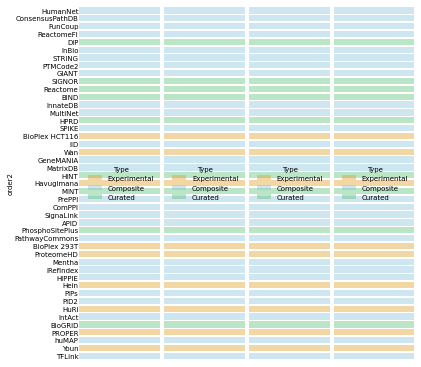

In [58]:
_, [ax2, ax1, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(6, 6.5), sharey=True, gridspec_kw={'wspace':0.05})

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    geneset= 'disgen'
    sns.barplot(full_network_rankings, x=48,y='order2', orient='h', hue='Type',order=[float(i) for i in range(len(full_network_rankings), 0, -1)], dodge=False, palette=['#ffa500', '#73c7e7', '#44cf6c'], 
                zorder=0, alpha=0.4, ax=ax, hue_order=['Experimental', 'Composite', 'Curated'])
    #sns.barplot(full_network_rankings, x=48,y='order', orient='h', hue='Type',order=[float(i) for i in range(0, 48, 1)], dodge=False, palette='Set2', zorder=0, alpha=0.5, ax=ax)
    #sns.barplot(full_network_rankings, x='bar',y='bar_y', orient='h', order = full_network_rankings['order'], ax=ax, hue='Type', dodge=False, palette='Set2', zorder=0, alpha=0.5)
    # add arrows between the pairs of points
    ax.set_xlim(0,47)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(length=0)
    ax.set_xticks([])
_ = ax1.set_yticklabels([network_names[x] for x in full_network_rankings.index])
plt.savefig('/cellar/users/snwright/Data/Transfer/pcnet/figures/Defense/3b_size_background.svg', bbox_inches='tight')

## Fig 3C - Correlations of performance between different gene sets sources

Calculate the correlations

In [16]:
correlations = full_network_rankings.loc[:, ["Performance-"+geneset for geneset in genesets]].corr(method=lambda x, y: spearmanr(x, y)[0])
pvals = full_network_rankings.loc[:, ["Performance-"+geneset for geneset in genesets]].corr(method=lambda x, y: spearmanr(x, y)[1])

Plot the correlations

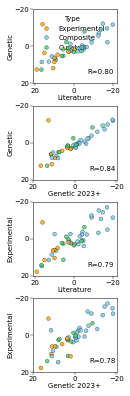

In [17]:
_, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, figsize=(1.5,5*4/3), gridspec_kw={'hspace':0.3})
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[1], y="Performance-"+genesets[0], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax1, legend=True)
r1 = correlations["Performance-"+genesets[1]]["Performance-"+genesets[0]]
ax1.set_xlabel(geneset_names[genesets[1]])
ax1.set_ylabel(geneset_names[genesets[0]])
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[2], y="Performance-"+genesets[0], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax2, legend=False)
r2 = correlations["Performance-"+genesets[2]]["Performance-"+genesets[0]]
ax2.set_xlabel(geneset_names[genesets[2]])
ax2.set_ylabel(geneset_names[genesets[0]])
sns.scatterplot(full_network_rankings, x="Performance-"+genesets[1], y="Performance-"+genesets[3], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax3, legend=False)
r3 = correlations["Performance-"+genesets[1]]["Performance-"+genesets[3]]
ax3.set_xlabel(geneset_names[genesets[1]])
ax3.set_ylabel(geneset_names[genesets[3]])

sns.scatterplot(full_network_rankings, x="Performance-"+genesets[2], y="Performance-"+genesets[3], hue='Type', edgecolor='black', zorder=100, s=15, 
                alpha=0.8, palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], ax=ax4, legend=False)
r4 = correlations["Performance-"+genesets[2]]["Performance-"+genesets[3]]
ax4.set_xlabel(geneset_names[genesets[2]])
ax4.set_ylabel(geneset_names[genesets[3]])

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    r=[r1,r2,r3,r4][i]
    ax.annotate(f"R={r:.2f}", xy=(-7,15))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-20, 0,  20])
    ax.set_yticks([-20, 0, 20])

ax1.invert_xaxis()
ax1.invert_yaxis()
ax2.invert_xaxis()
ax2.invert_yaxis()
ax3.invert_xaxis()
ax3.invert_yaxis()
ax4.invert_xaxis()
ax4.invert_yaxis()
plt.savefig(figdir + "Fig3C_Performance_correlations.jpg", dpi=300, bbox_inches="tight")

## Fig 3D - Interaction-type-specific performance results

Load and plot the results for interaction-type-specific results from HumanNet and GeneMANIA:
* AUPRC
* Performance
* Performance Gain
* Network Coverage
* Gene set sizes

In [18]:
type_specific_results = pd.read_csv(os.path.join(gitdir,'StateOfTheInteractomes_Notebooks/Data/Fig3D_type_specific_results.csv'))

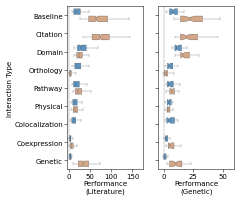

In [19]:
_, [ax, ax1] = plt.subplots(nrows=1, ncols=2,figsize=(3,3), sharey=True)
ax = sns.boxplot(data=type_specific_results[(~type_specific_results.Network.isin(['GM_genetic', 'GM_coexp_90', 'humannet.v3.gn'])) & (type_specific_results['GeneSet']=='Performance_disgen')], 
                    y='InteractionType', x='Performance', hue='parent', linewidth=0.25,fliersize=0,notch=True, ax = ax, 
                    order=['Baseline', 'Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], gap=0.2, linecolor='#343a40', saturation=1, whis=(5,95))
ax.tick_params(labelsize=7)
ax.set_ylabel("Interaction Type", fontsize=7)
ax.set_xlabel("Performance\n(Literature)", fontsize=7)
# plot vertical line on ax
ax.vlines(x=0, ymin=-1, ymax=8, color='black', lw=0.25, zorder=0, linestyles='--')
ax.set_xlim((-5, 175))
ax.set_ylim(7.5, -0.5)
_ =ax.set_xticks([0,50,100, 150])

ax1 = sns.boxplot(data=type_specific_results[(~type_specific_results.Network.isin(['GM_genetic', 'GM_coexp_90', 'humannet.v3.gn'])) & (type_specific_results['GeneSet']=='Performance_gwas')], 
                    y='InteractionType', x='Performance', hue='parent', linewidth=0.25,fliersize=0,notch=True, ax = ax1, 
                    order=['Baseline', 'Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], gap=0.2, linecolor='#343a40', saturation=1, whis=(5,95))

ax1.tick_params(labelsize=7)

ax1.set_xlabel("Performance\n(Genetic)", fontsize=7)

ax1.vlines(x=0, ymin=-1, ymax=8, color='black', lw=0.25, zorder=0, linestyles='--')
ax1.set_xlim((-5, 60))
ax1.set_ylim(8.5, -0.5)
_ =ax1.set_xticks([0,25, 50])


ax1.tick_params(labelsize=7, width=0.5)
ax.tick_params(labelsize=7, width=0.5)

plt.savefig(figdir+"Fig3D_type_specific_results.jpg", bbox_inches='tight', dpi=300)

## EV Figures

### EV3A - Summary metrics of gene set recovery

Plot distributions of all metrics for Literature and Genetic gene sets


#### AUPRC

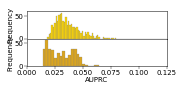

In [20]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').AUPRC.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='gold', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').AUPRC.median().plot(kind='hist',bins=20,
                                                                ax=ax2, edgecolor='grey', color='goldenrod', linewidth=0.25, density=False)


plt.xlim(0, 0.125)
ax2.set_xlabel("AUPRC")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "EV3A_auprc_histograms.jpg", dpi=300, bbox_inches="tight")

#### Performance

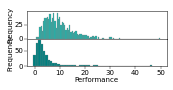

In [21]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').Performance.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='lightseagreen', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').Performance.median().plot(kind='hist',bins=50,
                                                                ax=ax2, edgecolor='grey', color='teal', linewidth=0.25, density=False)


ax2.set_xlabel("Performance")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "EV3A_performance_histograms.jpg", dpi=300, bbox_inches="tight")

#### Performance Gain

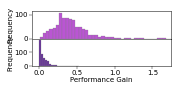

In [22]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True, gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].groupby('Disease').Gain.median().plot(kind='hist',bins=100,
                                                                ax=ax1, edgecolor='grey', color='mediumorchid', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].groupby('Disease').Gain.median().plot(kind='hist',bins=20,
                                                                ax=ax2, edgecolor='grey', color='rebeccapurple', linewidth=0.25, density=False)

plt.xlim(-0.1, 1.75)
ax2.set_xlabel("Performance Gain")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "EV3A_gain_histograms.jpg", dpi=300, bbox_inches="tight")

#### Network Coverage

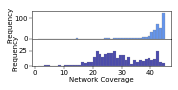

In [23]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True,  gridspec_kw={'hspace':0})
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[1]]].value_counts('Disease').plot(kind='hist',bins=[i for i in range(1, 46)],
                                                                ax=ax1, edgecolor='grey', color='cornflowerblue', linewidth=0.25, density=False)
gsr_full_results[gsr_full_results.GeneSet == geneset_names[genesets[0]]].value_counts('Disease').plot(kind='hist',bins=[i for i in range(1, 46)],
                                                                ax=ax2, edgecolor='grey', color='darkblue', linewidth=0.25, density=False,alpha=0.7)
ax2.set_ylim(0, 45)
ax2.set_xlabel("Network Coverage")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "EV3A_coverage_histograms.jpg", dpi=300, bbox_inches="tight")

#### Gene Set Sizes

In [24]:
disgen_sets = load_node_sets(os.path.join(gitdir, 'Data', 'disgen.genesets'))
gwas_sets = load_node_sets(os.path.join(gitdir, 'Data', 'gwas.genesets'))
disgen_sizes = {net:len(disgen_sets[net]) for net in disgen_sets}
gwas_sizes = {net:len(gwas_sets[net]) for net in gwas_sets}

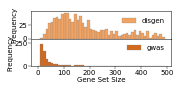

In [25]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 1), sharex=True,  gridspec_kw={'hspace':0})
pd.DataFrame({'disgen':disgen_sizes}).plot(kind='hist', bins=[i*10 for i in range(0, 50)], ax=ax1, edgecolor='grey', color='sandybrown', linewidth=0.25, density=False)
pd.DataFrame({'gwas':gwas_sizes}).plot(kind='hist', bins=[i*10 for i in range(0, 50)], ax=ax2, edgecolor='grey', color='chocolate', alpha=1, linewidth=0.25, density=False)
#plt.xlim(-0.1, 1.75)
ax2.set_ylim(0, 300)
ax2.set_xlabel("Gene Set Size")
ax1.tick_params(axis='x', length=0)
plt.savefig(figdir + "FigEV3A_sizes_histograms.jpg", dpi=300, bbox_inches="tight")

### EV3B - Performance for reduced versus original gene sets

Gene set recovery performance is proportional to interactome size. However, this could be driven by increased coverage of gene sets, rather than greater information content. Here we assess performance on identical gene sets to better assess why large interactomes have high gene set recovery performance.

In [26]:
reduced_nets = ['BioGRID', 'BioPlex 293T', 'ConsensusPathDB', 'DIP', 'FunCoup', 'GIANT',
       'HPRD', 'HumanNet', 'InBio', 'InnateDB', 'MatrixDB', 'PTMCode2',
       'PrePPI', 'ReactomeFI', 'STRING', 'SignaLink']

reduced_er = {'Genetic (reduced)': gsr_full_results[gsr_full_results.GeneSet=='Genetic (Reduced)'].pivot_table(columns='Network', index='Disease', values='Performance'),
             'Literature (reduced)':gsr_full_results[gsr_full_results.GeneSet=='Literature (Reduced)'].pivot_table(columns='Network', index='Disease', values='Performance'),
              'Literature':gsr_full_results[gsr_full_results.GeneSet=='Literature'].pivot_table(columns='Network', index='Disease', values='Performance'),
              'Genetic':gsr_full_results[gsr_full_results.GeneSet=='Genetic'].pivot_table(columns='Network', index='Disease', values='Performance')
             }

In [27]:
size_stats = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig1B_network_sizes.csv'), index_col=0)
edge_dict = size_stats.set_index('Name')['Interaction Count'].to_dict()
node_dict = size_stats.set_index('Name')['Gene Count'].to_dict()

The group of 16 interactomes was selected to represent a range of interactome sizes:

Text(0, 0.5, 'Interaction Count')

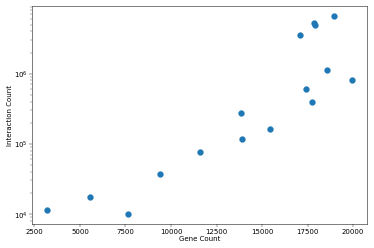

In [28]:
plt.scatter([node_dict[x] for x in reduced_nets], [edge_dict[y] for y in reduced_nets])
plt.yscale('log')
plt.xlabel('Gene Count')
plt.ylabel('Interaction Count')

First, we examing the change in the correlation between interactome size and mean gene set recovery performance. This is a measure globally across all gene sets analyzed

In [29]:
def plot_size_correlations(reduced_er, group1, group2, edge_dict, node_dict, nets, ax=None):
    
    plot_df = reduced_er[group1].loc[:, nets].melt(ignore_index=False, var_name="Network", value_name="Performance").reset_index().rename(columns={"index":'Geneset'})
    plot_df['EdgeCount'] = plot_df.Network.apply(lambda x: edge_dict[x])
    plot_df['NodeCount'] = plot_df.Network.apply(lambda x: node_dict[x])
    plot_df_full = reduced_er[group2].loc[:, nets].melt(ignore_index=False, var_name="Network", value_name="Performance").reset_index().rename(columns={"index":'Geneset'})
    plot_df_full['EdgeCount'] = plot_df_full.Network.apply(lambda x: edge_dict[x])
    plot_df_full['NodeCount'] = plot_df_full.Network.apply(lambda x: node_dict[x])
    sns.regplot(data = plot_df.groupby('Network').mean().reset_index(), x='EdgeCount', y='Performance', 
                logx=True, ci=95, label=group1, ax=ax, scatter_kws={'s':10}, line_kws={'linewidth':0.75})
    sns.regplot(data = plot_df_full.groupby('Network').mean().reset_index(), x='EdgeCount', y='Performance', 
                logx=True, ci=95, label=group2, ax=ax, scatter_kws={'s':10}, line_kws={'linewidth':0.75})
    if ax is None:
        ax = plt.gca()
    ax.set_ylabel('Mean Performance')
    ax.set_xscale('log')
    ax.set_xlabel('Interaction Count')

    ax.legend()
    return plot_df.groupby('Network').mean(), plot_df_full.groupby('Network').mean()

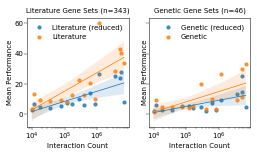

In [30]:
_ , [ax1, ax2] = plt.subplots(1, 2, figsize=(4,2), sharey=True)
_ = plot_size_correlations(reduced_er, 'Literature (reduced)', 'Literature', edge_dict, node_dict, nets=reduced_nets, ax=ax1)
_ = ax1.set_title('Literature Gene Sets (n=343)', fontsize=7)
_ = plot_size_correlations(reduced_er, 'Genetic (reduced)', 'Genetic', edge_dict, node_dict,nets=reduced_nets,ax=ax2)
_ = ax2.set_title('Genetic Gene Sets (n=46)', fontsize=7)
plt.savefig(figdir + "FigEV3B_reduced_geneset_scatters.jpg", dpi=300, bbox_inches="tight")

### EV3C - Slopes of size-adjusted performance for reduced gene sets

Then, we examine the slopes generated when fitting a linear regression model of performance for each gene set to the interactome size. Extracting these slopes allows us to examine how consistent differences are across all gene sets.

In [31]:
## Load fit data
slope_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigEV3C_slope_data.tsv'), sep='\t')

In [32]:
def plot_slope_hists(slope_data, geneset, name1, name2, ax=None):
    combined_data = slope_data[slope_data.GeneSet==geneset].melt(id_vars=['Disease', 'GeneSet'], value_name='Slope', var_name=geneset)
    sns.histplot(data=combined_data, x='Slope', hue=geneset, kde=True, ax=ax, bins=[i for i in range(-5, 30)], alpha=0.3)
    ax.set_ylabel('Gene Set Count')
    return combined_data.groupby(geneset).Slope.median()

Medians:  Literature
Slope_Full       7.185544
Slope_Reduced    4.540508
Name: Slope, dtype: float64
Medians:  Genetic
Slope_Full       3.923959
Slope_Reduced    1.504175
Name: Slope, dtype: float64


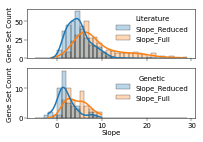

In [33]:
_, [ax1, ax2] = plt.subplots(2, 1, figsize=(3,2), sharex=True)
x1 = plot_slope_hists(slope_data, 'Literature', 'Reduced', 'Original', ax=ax1)
print('Medians: ', x1)
x2 = plot_slope_hists(slope_data, 'Genetic', 'Reduced', 'Original', ax=ax2)
print('Medians: ', x2)
plt.savefig(figdir + "FigEVC_reduced_geneset_slope_histograms.jpg", dpi=300, bbox_inches="tight")

Test the distribution of differences for skew

In [34]:
slope_data['diff'] = slope_data['Slope_Full'] - slope_data['Slope_Reduced']

<AxesSubplot:xlabel='diff', ylabel='Count'>

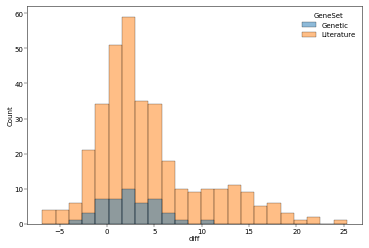

In [35]:
sns.histplot(data = slope_data ,x='diff', hue='GeneSet')

In [36]:
skewtest(list(slope_data[slope_data.GeneSet=='Genetic']['diff']), nan_policy='omit')

SkewtestResult(statistic=1.2740978841295476, pvalue=0.2026287282092447)

In [37]:
skewtest(list(slope_data[slope_data.GeneSet=='Literature']['diff']), nan_policy='omit')

SkewtestResult(statistic=6.936704767965834, pvalue=4.013513494150971e-12)

Wilcoxon/Sign Rank test

In [38]:
def perform_paired_slope_test(slope_data, geneset, wilcox=True):
    #The Wilcoxon test should only be used when the differences between the pair data do not exhibit significant skew.  
    combined_data = slope_data[slope_data.GeneSet==geneset]
    print("Means:", np.mean(combined_data[f'Slope_Reduced']), np.mean(combined_data[f'Slope_Full']))
    print("Medians:", np.median(combined_data[f'Slope_Reduced']), np.median(combined_data[f'Slope_Full']))
    if wilcox:
        stats = wilcoxon(combined_data[f'Slope_Reduced'], combined_data[f'Slope_Full'])
    else:
        stats = sign_test(combined_data[f'Slope_Full']-combined_data[f'Slope_Reduced'])
    return stats

In [39]:
perform_paired_slope_test(slope_data, 'Literature', wilcox=False)

Means: 4.836071078265695 9.110245433171647
Medians: 4.540508249589887 7.185544021468002


(108.5, 8.814347881108425e-34)

In [40]:
perform_paired_slope_test(slope_data, 'Genetic')

Means: 1.9753658485820287 4.430179218380134
Medians: 1.5041745273268567 3.9239587839728696


WilcoxonResult(statistic=119.0, pvalue=4.1237663038180835e-06)

### EV3D - Sizes of interaction-type-specific networks

In [41]:
type_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigEV3D_type_specific_stats.tsv'), sep='\t', index_col=0)

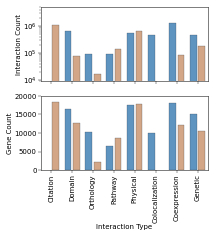

In [42]:
_, [ax, ax1] = plt.subplots(nrows=2, ncols=1,figsize=(3,3), sharex=True)
sns.barplot(data=type_df, 
                    x='Type', y='Interaction Count', hue='Network', linewidth=0.25, ax = ax, 
                    order=['Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], hue_order=[ 'GeneMania', 'HumanNet'], gap=0.2, edgecolor='#343a40', saturation=1)
ax.tick_params(labelsize=7)
ax.set_xlabel("Interaction Type", fontsize=7)
ax.set_ylabel("Interaction Count", fontsize=7)
# plot vertical line on ax
ax.set_yscale('log')
ax.set_ylim(9e3, 5e6)
sns.barplot(data=type_df, 
                    x='Type', y='Gene Count', hue='Network', linewidth=0.25, ax = ax1, 
                    order=['Citation', 'Domain', 'Orthology', 'Pathway', 'Physical', 'Colocalization', 'Coexpression', 'Genetic'], zorder=10,
                    legend=False, palette=['#5e94c0','#d2a686' ], hue_order=[ 'GeneMania', 'HumanNet'], gap=0.2, edgecolor='#343a40', saturation=1)
ax1.tick_params(axis= 'x', labelsize=7, rotation=90)
ax1.set_xlabel("Interaction Type", fontsize=7)
ax1.set_ylabel("Gene Count", fontsize=7)
# plot vertical line on ax
ax1.set_ylim(0, 20000)
plt.savefig(figdir + "FigEv3D_type_specific_net_sizes.jpg", dpi=300, bbox_inches="tight")

###  EV3E - Jaccard similarities of networks

Example analysis for calculating the Jaccard similarity of networks. 

In [43]:
def make_pair_str(geneA, geneB):
    return '_'.join([str(g) for g in sorted([int(geneA), int(geneB)])])
        
J = {}
for i, pref1 in enumerate(stats.prefixes):
    for pref2 in stats.prefixes[(i+1):]:
        edges1 = pd.read_csv(stats.edge_files[pref1], sep='\t')
        edges1['Pair'] = edges1.apply(lambda x: make_pair_str(x.Entrez_A, x.Entrez_B), axis=1)
        edges2 = pd.read_csv(stats.edge_files[pref2], sep='\t')
        edges2['Pair'] = edges2.apply(lambda x: make_pair_str(x.Entrez_A, x.Entrez_B), axis=1)
        union = edges1.merge(edges2, on='Pair', how='outer')
        intersect = edges1.merge(edges2, on='Pair', how='inner')
        J[(pref1, pref2)] = len(intersect)/len(union)        
        

In [44]:
print(J)

{('dip', 'pid2'): 0.029705554369231498, ('dip', 'wan'): 0.02932195283470071, ('pid2', 'wan'): 0.0056794541066822}


Visualize all pre-computed Jaccard Similarities

In [45]:

j_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigEV3E_Jaccard_mat.tsv'), sep='\t', index_col=0)

In [46]:
all_mat = j_df.loc[:, ([x for x in j_df.columns if x in j_df.index.values])]

<AxesSubplot:ylabel='type1'>

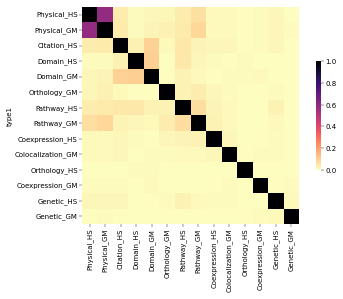

In [50]:
cg = sns.clustermap(all_mat, cmap='RdPu', vmin=0, vmax=0.65, method='ward')
plt.close()
sns.heatmap(all_mat.iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], cmap='magma_r', vmin=0, 
            vmax=1, square=True, cbar_kws={'shrink':0.5}, cbar=True)

Plot with annotation bars

In [47]:
parents = j_df.loc[:, ('parent', 'height')].reset_index()

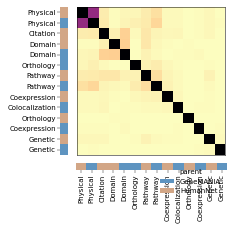

In [51]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(3,3), 
                                           gridspec_kw={'wspace':0.1, 'hspace':0.1, 'height_ratios':[1,  0.05], 
                                                        'width_ratios':[0.05, 1]})

sns.heatmap(all_mat.iloc[cg.dendrogram_row.reordered_ind, cg.dendrogram_col.reordered_ind], cmap='magma_r', vmin=0, 
            vmax=1, square=True, ax = ax2, cbar_kws={'shrink':0.5}, cbar=False)

sns.barplot(parents.iloc[cg.dendrogram_row.reordered_ind], x ='height', y='type1', hue='parent', ax=ax1, orient='h', 
            saturation=1, palette=['#5e94c0','#d2a686' ], 
            hue_order = ['GeneMANIA', 'HumanNet'], width=1, legend=False)
sns.barplot(parents.iloc[cg.dendrogram_row.reordered_ind], y ='height', x='type1', hue='parent', ax=ax4, orient='v', 
            saturation=1, palette=['#5e94c0','#d2a686' ], 
            hue_order = ['GeneMANIA', 'HumanNet'], width=1)
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlim(0,1)
ax1.set_xticks([])
ax4.set_ylim(0,1)
ax4.set_yticks([])
_ = ax4.set_xticks([i for i in range(len(all_mat))], labels=[all_mat.index[x].split('_')[0] for x in cg.dendrogram_col.reordered_ind], rotation=90)
_ = ax1.set_yticks([i for i in range(len(all_mat.columns))], labels=[all_mat.columns[x].split('_')[0] for x in cg.dendrogram_row.reordered_ind])
for ax in [ax1, ax2, ax4, ax3]:
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in [ax1, ax3, ax4]:
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax2.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(True)

ax3.set_xticks([])
ax3.set_yticks([])
plt.savefig(os.path.join(figdir, 'FigEV5E_Pair Jaccard_fixed_cbar.jpg'), dpi=300, bbox_inches='tight')